## Data exploration: 1.6 GB CrowdAi

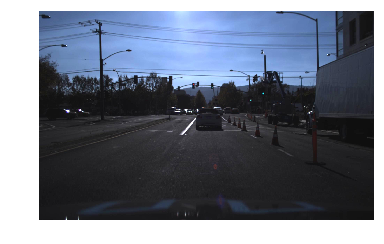

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle 
import time
import pandas as pd
%matplotlib inline

#read in image
image = mpimg.imread('object-detection-crowdai/1479504050351127195.jpg')
plt.imshow(image);
plt.axis('off');

In [2]:
#checkout pandas dataframe labels
pd_dframe = pd.read_csv('object-detection-crowdai/labels.csv')
print('Size of image data set ', pd_dframe.size)
pd_dframe.head(n=10)

Size of image data set  504448


,xmin,xmax,ymin,ymax,Frame,Label,Preview URL
0,785,533,905,644,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1,89,551,291,680,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
2,268,546,383,650,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
3,455,522,548,615,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
4,548,522,625,605,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
5,1726,484,1919,646,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
6,758,557,807,617,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
7,633,561,680,597,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
8,682,557,718,593,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
9,710,540,836,665,1479498372942264998.jpg,Car,http://crowdai.com/images/c3AY-ptjXfT_oC9F/vis...


In [3]:
#We don't need pedestrians in data set so drop all rows with the pedestrian label, also drop Preview URL
pd_dframe = pd_dframe[pd_dframe.Label != 'Pedestrian']
del pd_dframe['Preview URL']

In [4]:
print('Size of image data set post pedestrian removal ', pd_dframe.size)
#Draw bounding boxes around images given coordinates, each image has multiple bounding boxes annotated to it
pd_dframe.tail()

Size of image data set post pedestrian removal  398334


,xmin,xmax,ymin,ymax,Frame,Label
72059,958,559,1045,621,1479506176491553178.jpg,Car
72060,1038,558,1122,630,1479506176491553178.jpg,Car
72061,667,558,747,626,1479506176491553178.jpg,Car
72062,730,568,818,613,1479506176491553178.jpg,Car
72063,435,551,532,589,1479506176491553178.jpg,Car


In [5]:
#There is something off about the coordinates, particularly 
#with regards the min max values of bounding box coordinates, 
#further investigations shows that they should be switched arounds as follows:
pd_dframe.columns = ['ymin', 'xmin', 'ymax', 'xmax', 'Frame', 'Label']
#pd_dframe.tail()

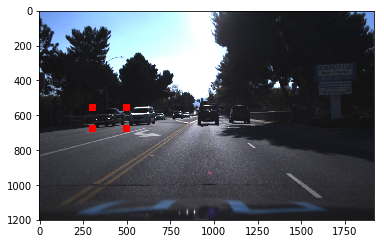

In [6]:
#Pick random image no and confirm that image coordinates all check out
no  = 25003
image_loc = (pd_dframe.iloc[no]['Frame'])
x1 = pd_dframe.iloc[no]['xmin']  
x2 = pd_dframe.iloc[no]['xmax'] 
y1 = pd_dframe.iloc[no]['ymin'] 
y2 = pd_dframe.iloc[no]['ymax']  

image = mpimg.imread('object-detection-crowdai/'+image_loc)
image_sz = image.shape
test = pd_dframe.iloc[no]
#Remember to plot bounding boxes, using y, x coordinates
plt.imshow(image);
plt.plot(y1, x1, 'rs')
plt.plot(y1, x2, 'rs')
plt.plot(y2, x1, 'rs')
plt.plot(y2, x2, 'rs')

In [13]:
import matplotlib.patches as patches
def get_image_name(df,ind):
    #Get image by name and all bounding box coordinates
    file_name = "object-detection-crowdai/"+df.iloc[ind]['Frame']
    img = cv2.imread(file_name)
    img_size = np.shape(img)
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    name_str = df.iloc[ind]['Frame']
     
    #Get all box coordinates of given image
    bb_boxes = df[df['Frame'] == name_str].reset_index()

    return img, bb_boxes
 
def get_mask_seg(img,bb_boxes_f): 
    # Get bounding masks   
    img_mask = np.zeros_like(img[:,:,0])
    
    for i in range(len(bb_boxes_f)):
        bb_box_i = [bb_boxes_f.iloc[i]['ymin'],bb_boxes_f.iloc[i]['xmin'],
                bb_boxes_f.iloc[i]['ymax'],bb_boxes_f.iloc[i]['xmax']]
        img_mask[bb_box_i[1]:bb_box_i[3],bb_box_i[0]:bb_box_i[2]]= 1.
        img_mask = np.reshape(img_mask,(np.shape(img_mask)[0],np.shape(img_mask)[1],1))
    return img_mask

def plot_im_bbox(im,bb_boxes):
    #Draw bounding boxes around vehicles
    f, axarr = plt.subplots(1, 2)
    axarr[1].imshow(im)
    axarr[0].set_title('Original image')
    axarr[0].imshow(im)
    for index, row in bb_boxes.iterrows():
        rect = patches.Rectangle(
        (row['ymin'], row['xmin']),   # (x,y)
        row['ymax']-row['ymin'],      # width
        row['xmax'] - row['xmin'],    # height
        )
        axarr[1].add_patch(rect)
        axarr[1].set_title('Cars with bounding boxes')
    print(img.shape)
    plt.show()

(1200, 1920, 3)


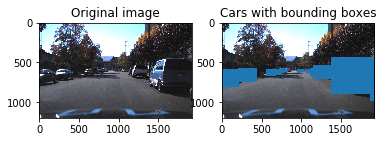

In [14]:
img, bb_boxes = get_image_name(pd_dframe, 100)
plot_im_bbox(img, bb_boxes)

In [40]:
#Next up make simple data generators
#Test set is comprised of 2000 images examples

img_rows = 1200
img_cols = 1920
    
def generate_train_batch(data, batch_size = 32):
    #Where data is a pandas dataframe
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_masks = np.zeros((batch_size, img_rows, img_cols, 1))
    
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data)-2000)
            img,bb_boxes = get_image_name(data, i_line)
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask
            
        yield batch_images, batch_masks
        
def generate_test_batch(data,batch_size = 32): 
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_masks = np.zeros((batch_size, img_rows, img_cols, 1))
    
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(2000)
            img,bb_boxes = get_image_name(data, i_line)
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask
            
        yield batch_images, batch_masks

In [16]:
##### Testing the generator
training_gen = generate_train_batch(pd_dframe, 10)

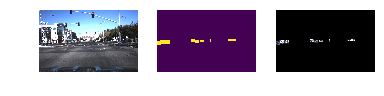

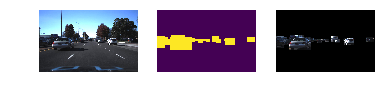

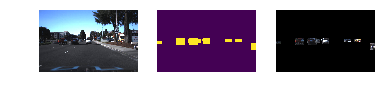

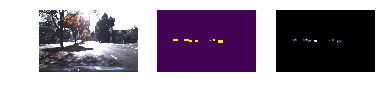

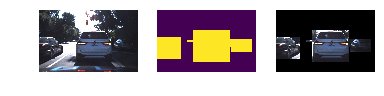

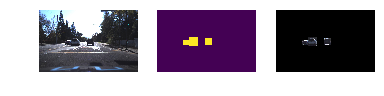

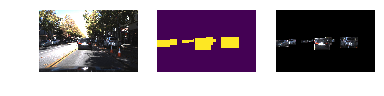

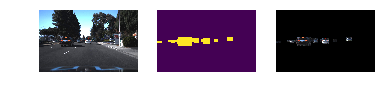

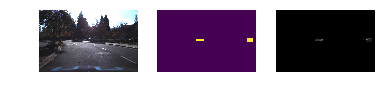

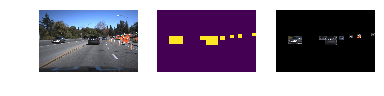

In [17]:
batch_img,batch_mask = next(training_gen)
### Plotting generator output
for i in range(10):
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(batch_mask[i],dtype=np.uint8)
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask));
    plt.axis('off')
    plt.show();


In [18]:
#Import all scipy, keras and tflow modules
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from scipy.ndimage.measurements import label
import time

Using TensorFlow backend.


In [25]:
#Awesome looks like all the generators work,
#next up we need to define the (intersection over union) IOU as used when training images segmentation:
smooth = 1.
def IOU_calc_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)    
    return -2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def IOU_calc(y_true, y_pred):
    return -IOU_calc_loss(y_true, y_pred)

In [26]:
### Defining a small Unet
def get_small_unet():
    inputs = Input((img_rows, img_cols,3))
    #Normalize images
    
    #Normal convolution downsampling
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv5)

    #Up convolve and merge previous downsampling
    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=3)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)
    conv7 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=3)
    conv8 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)
    conv9 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(conv9)

    #Add sigmoid layer to get segmentaion probability
    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    return model

In [29]:
training_gen = generate_train_batch(pd_dframe,1)
smooth = 1.
model = get_small_unet()
model.compile(optimizer=Adam(lr=1e-4),
              loss=IOU_calc_loss, metrics=[IOU_calc])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 1200, 1920, 3) 0                                            
____________________________________________________________________________________________________
convolution2d_96 (Convolution2D) (None, 1200, 1920, 8) 224         input_6[0][0]                    
____________________________________________________________________________________________________
convolution2d_97 (Convolution2D) (None, 1200, 1920, 8) 584         convolution2d_96[0][0]           
____________________________________________________________________________________________________
maxpooling2d_21 (MaxPooling2D)   (None, 600, 960, 8)   0           convolution2d_97[0][0]           
___________________________________________________________________________________________

In [30]:
history = model.fit_generator(training_gen,
            samples_per_epoch=1000,
                              nb_epoch=1)

Epoch 1/1
1000/1000 [==============================] - 1386s - loss: -0.2255 - IOU_calc: 0.2255  


In [32]:
model.save('Vehicle_detect_SmallUnet.h5')

In [45]:
testing_gen = generate_test_batch(pd_dframe,3)
batch_img, batch_mask = next(testing_gen)

In [46]:
import time

start = time.time()

pred_all= model.predict(batch_img)
end = time.time()
end-start

7.323625564575195

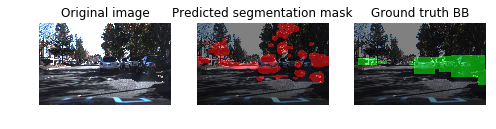

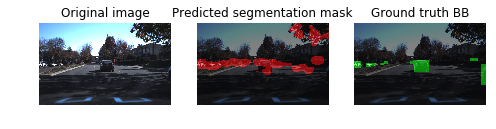

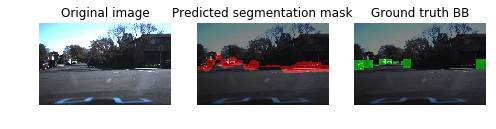

In [48]:
#Test on last frames of data
np.shape(pred_all)

for i in range(3):

    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(255*batch_mask[i],dtype=np.uint8)
    im_pred = np.array(255*pred_all[i],dtype=np.uint8)

    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]

    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)

    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title('Predicted segmentation mask')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(img_true)
    plt.title('Ground truth BB')
    plt.axis('off')
    plt.show()